In [17]:
%load_ext autoreload
%autoreload 2
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig, AutoTokenizer
from omegaconf import OmegaConf
import hydra
from einops import repeat
import pyvene as pv
import torch
import wandb
from tasks.regression import *
import os
import gc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
experiments = {
    "explicit-transformer": "1ejrnua7",
    "explicit-mlp": "hb9li9ry",
    "explicit-aux-transformer": "hzr77fqz",
    "implicit": "huqr2bcp",
}

In [74]:
EXP = 'explicit-transformer'

In [75]:
api = wandb.Api()
run = api.run(f'leogagnon/Explicit-Implicit/runs/{experiments[EXP]}')
artifact = api.artifact(f'leogagnon/Explicit-Implicit/model-{experiments[EXP]}:latest')
path = artifact.download()

wandb:   1 of 1 files downloaded.  


In [76]:
pl_module = RegressionICL.load_from_checkpoint(
    checkpoint_path=os.path.join(path,'model.ckpt'),
    strict=False,
    model=hydra.utils.instantiate(run.config['model_config']),
).to('cuda')

/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['w_predictor.weight', 'w_predictor.bias']


In [77]:
class MyConfig(PretrainedConfig):
    model_type = 'mymodel'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

class MyModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = pl_module.model
    def forward(self, x_c, y_c, x_q):
        return self.model(x_c, y_c, x_q) 

In [93]:
hf_model = MyModel(MyConfig())
if EXP == "implicit":
    pv_config = pv.IntervenableConfig(
        representations=[
            pv.RepresentationConfig(
                component=f"model.encoder.layers[{i}].output",
                intervention=pv.LowRankRotatedSpaceIntervention(
                    embed_dim=256, low_rank_dimension=1
                )
            )
            for i in [3,5]
        ]
    )
else:
    pv_config = pv.IntervenableConfig(
        representations=pv.RepresentationConfig(
            component="model.context_model.output",
            intervention=pv.LowRankRotatedSpaceIntervention(
                embed_dim=256, low_rank_dimension=10
            ),
        )
    )
pv_model = pv.IntervenableModel(config=pv_config, model=hf_model)
pv_model.set_device("cuda")

In [94]:
datamodule = hydra.utils.instantiate(run.config['experiment_config']['experiment']['data'])

In [95]:
opt = torch.optim.Adam(pv_model.get_trainable_parameters())
pv_model.model.eval()

train_loss_traj = []
val_loss_traj = []
for epoch in range(10):
    train_loss = []
    for batch in datamodule.train_dataloader():
        base = {
            "x_c": batch[0][0].cuda(),
            "y_c": batch[0][1].cuda(),
            "x_q": batch[1][0].cuda(),
        }
        c_len = batch[0][0].shape[1]

        # Different context, different queries, different latent
        x_c_source, x_q_source = datamodule.train_data.sample_x(c_len)
        w_source = datamodule.train_data.sample_function_params()
        source = {
            "x_c": x_c_source.cuda(),
            "y_c": datamodule.train_data.function(x_c_source, w_source).cuda(),
            "x_q": x_q_source.cuda(),
        }
        unit_locations = (
            {"sources->base": c_len - 1}
            if EXP == "implicit"
            else None
        )
        y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
        y_q_counterfactual = datamodule.train_data.function(
            batch[1][0], w_source
        ).cuda()

        loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)

        loss.backward()
        train_loss += [loss.detach().cpu().item()]
        opt.step()
        opt.zero_grad()

    train_loss_traj += [sum(train_loss) / len(train_loss)]
    print("Train loss :", train_loss_traj[-1])
    
    with torch.no_grad():
        for batch in datamodule.val_dataloader()[0]:
            gc.collect()
            base = {
                "x_c": batch[0][0].cuda(),
                "y_c": batch[0][1].cuda(),
                "x_q": batch[1][0].cuda(),
            }
            c_len = batch[0][0].shape[1]
            bs = batch[0][0].shape[0]

            # Different context, different queries, different latent
            x_c_source, x_q_source = datamodule.val_data["iid"].sample_x(
                batch[0][0].shape[1]
            )
            w_source = datamodule.val_data["iid"].sample_function_params()
            source = {
                "x_c": x_c_source.cuda(),
                "y_c": datamodule.val_data["iid"].function(x_c_source, w_source).cuda(),
                "x_q": x_q_source.cuda(),
            }

            unit_locations = (
                {"sources->base": c_len - 1}
                if EXP == "implicit"
                else None
            )
            y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
            y_q_counterfactual = (
                datamodule.val_data["iid"].function(batch[1][0], w_source).cuda()
            )

            loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)
            val_loss_traj += [loss.cpu().item()]
            print("Val loss :", loss)

Train loss : 3.358053003038679
Val loss : tensor(1.9941, device='cuda:0')
Train loss : 1.3665763139724731
Val loss : tensor(0.7357, device='cuda:0')
Train loss : 0.594431106533323
Val loss : tensor(0.3486, device='cuda:0')
Train loss : 0.3018730580806732
Val loss : tensor(0.2431, device='cuda:0')
Train loss : 0.24011949130467006
Val loss : tensor(0.1534, device='cuda:0')
Train loss : 0.14894988813570567
Val loss : tensor(0.1174, device='cuda:0')
Train loss : 0.09517353347369603
Val loss : tensor(0.0777, device='cuda:0')
Train loss : 0.06927719339728355
Val loss : tensor(0.0543, device='cuda:0')
Train loss : 0.0401938371360302
Val loss : tensor(0.0351, device='cuda:0')
Train loss : 0.03685593977570534
Val loss : tensor(0.0309, device='cuda:0')


In [24]:
implicit_mse = val_loss_traj[-1]

In [36]:
explicitMLP_mse = val_loss_traj[-1]

In [44]:
explicitTSF_mse = val_loss_traj[-1]

In [45]:
counterfactual_mse = [implicit_mse, explicitTSF_mse, explicitMLP_mse]

# Figure

In [ ]:
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-aux-transformer": sns.color_palette()[4],
    "explicit-known": sns.color_palette()[2],
}

data_alchemy = pd.read_csv("data/alchemy_interp.csv")
data_alchemy = (
    data_alchemy.groupby(["Model", "Latent"])
    .apply(
        lambda x: x[
            x["Location"]
            == x.groupby(["Location"])["Baseline-adjusted IIA"].mean().idxmax()
        ],
        include_groups=False,
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(2, 1.1))

sns.barplot(
    data=data_alchemy,
    ax=ax,
    x="Latent",
    y="Baseline-adjusted IIA",
    hue="Model",
    hue_order=["Implicit", "Explicit Transformer", "Explicit MLP"],
    palette=[
        default_model_colours[m]
        for m in ["implicit", "explicit-transformer", "explicit-mlp"]
    ],
    errorbar=lambda x: (x.min(), x.max()),
    err_kws={"linewidth": 1.25},
)
ax.set(
    title="Alchemy",
    xlabel="Latent component",
    ylabel=r"Relative accuracy ($\uparrow$)",
)

ax.legend().remove()

fig.savefig("saved/interpretability_intervention.pdf")
plt.show()

In [65]:
# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0.5, 1.0, 'Alchemy'),
 Text(0.5, 0, 'Latent component'),
 Text(0, 0.5, 'Counterfactual MSE ($\\uparrow$)')]

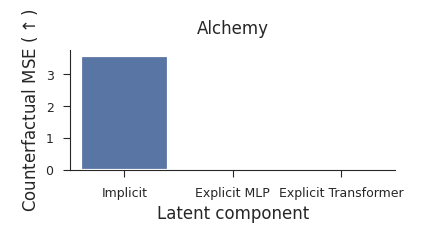

In [73]:
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-aux-transformer": sns.color_palette()[4],
    "explicit-known": sns.color_palette()[2],
}

fig, ax = plt.subplots(figsize=(2, 1.1))

sns.barplot(
    data=pd.DataFrame(
        {
            "Model": ["Implicit", "Explicit MLP", "Explicit Transformer"],
            "Counterfactual MSE": counterfactual_mse,
        }
    ),
    ax=ax,
    x="Model",
    y="Counterfactual MSE",
    err_kws={"linewidth": 1.25},
)
ax.legend().remove()
ax.set(
    title="Alchemy",
    xlabel="Latent component",
    ylabel=r"Counterfactual MSE ($\uparrow$)",
)